In [97]:
import pandas as pd
import joblib
import json
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from service.app_api.features.extractor import FeatureExtractor
from service.app_api.features.final_processing import CustomColumnTransformer
from service.app_api.configs import settings
from tuning.optuna_tuning import OptunaTuner
import optuna
import wandb

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
# Base classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# Meta classifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [2]:
try:
    customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')
except:
    customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
    joblib.dump(customers, 'customers.joblib')
    joblib.dump(sales, 'sales.joblib')

In [3]:
fe = FeatureExtractor(target_month=3, perform_split=True, generation_type='continuous', filtering_set='sales', period=60, subperiod=15)
X_train, X_test, y_train, y_test = fe.transform(sales=sales, customers=customers)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


In [100]:
qty_cols = [col for col in X_train.columns if 'qty' in col]
col_transform = CustomColumnTransformer(
    cols_for_scaling=qty_cols,
    scaling_algo=RobustScaler(),
    cols_for_ohe=None,
    cols_for_winsor=None,
    cols_to_skip=None
)

In [101]:
X_train_trans = col_transform.fit_transform(X_train)
X_test_trans = col_transform.fit_transform(X_test)

## SVC base model

In [ ]:
# svc_op = OptunaTuner(
#     SVC,
#     accuracy_score,
#     direction='maximize',
#     random_state=571,
#     verbose=False,
#     tol=1
# )
# svc_op.fit(
#     50, X_train_trans, y_train, X_test_trans, y_test,
#     ('C', 'float', 1e-3, 1.0),
#     ('kernel', 'categorical', ['linear', 'poly', 'rbf', 'sigmoid']),
#     ('degree', 'int', 1, 15)
# )

In [ ]:
# optuna.visualization.plot_optimization_history(svc_op.study)

In [ ]:
# svc_op.model.get_params()

In [103]:
svc_best = SVC(
    verbose=False,
    random_state=571,
    tol=1
)
svc_best.fit(X_train_trans, y_train)
svc_train_preds = svc_best.predict(X_train_trans)
svc_test_preds = svc_best.predict(X_test_trans)

In [104]:
print('Train:')
print(classification_report(y_train, svc_train_preds), '\n')
print('Test:')
print(classification_report(y_test, svc_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74     25669
           1       0.81      0.65      0.72     29752

    accuracy                           0.73     55421
   macro avg       0.74      0.74      0.73     55421
weighted avg       0.74      0.73      0.73     55421
 

Test:
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      8603
           1       0.81      0.64      0.72      9871

    accuracy                           0.73     18474
   macro avg       0.74      0.73      0.73     18474
weighted avg       0.74      0.73      0.73     18474



## KNN base model

In [105]:
knn_op = OptunaTuner(
    KNeighborsClassifier,
    accuracy_score,
    direction='maximize',
    n_jobs=7
)
knn_op.fit(
    100, X_train_trans, y_train, X_test_trans, y_test,
    ('n_neighbors', 'int', 1, 50)
)

In [106]:
optuna.visualization.plot_optimization_history(knn_op.study)

In [107]:
knn_best = KNeighborsClassifier(**knn_op.model.get_params())
knn_best.fit(X_train_trans, y_train)
knn_train_preds = knn_best.predict(X_train_trans)
knn_test_preds = knn_best.predict(X_test_trans)

In [108]:
print('Train:')
print(classification_report(y_train, knn_train_preds), '\n')
print('Test:')
print(classification_report(y_test, knn_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     25669
           1       0.79      0.78      0.78     29752

    accuracy                           0.77     55421
   macro avg       0.77      0.77      0.77     55421
weighted avg       0.77      0.77      0.77     55421
 

Test:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      8603
           1       0.78      0.76      0.77      9871

    accuracy                           0.76     18474
   macro avg       0.76      0.76      0.76     18474
weighted avg       0.76      0.76      0.76     18474



## Load best Random Forest model

In [75]:
api = wandb.Api()
run = api.run(f"{settings.SETTINGS['WANDB_ENTITY']}/Random-Forest-Classifier/qzbhynm9")

In [76]:
rf_config = json.loads(run.json_config)
rf_params = {}
for param in rf_config:
    rf_params.update({param: rf_config[param]['value']})

In [110]:
rf_best = RandomForestClassifier(**rf_params)
rf_best.fit(X_train_trans, y_train)
rf_train_preds = rf_best.predict(X_train_trans)
rf_test_preds = rf_best.predict(X_test_trans)

In [111]:
print('Train:')
print(classification_report(y_train, rf_train_preds), '\n')
print('Test:')
print(classification_report(y_test, rf_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     25669
           1       0.80      0.79      0.79     29752

    accuracy                           0.78     55421
   macro avg       0.78      0.78      0.78     55421
weighted avg       0.78      0.78      0.78     55421
 

Test:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8603
           1       0.79      0.78      0.79      9871

    accuracy                           0.77     18474
   macro avg       0.77      0.77      0.77     18474
weighted avg       0.78      0.77      0.77     18474



## Identify overlaps of models errors

In [112]:
base_models_df = pd.DataFrame(
    {
        'svc_preds': svc_test_preds,
        'knn_preds': knn_test_preds,
        'rf_preds': rf_test_preds,
        'y_true': y_test
    }
)

In [113]:
base_models_df['svc_accuracy'] = base_models_df.apply(lambda x: 'error' if x['svc_preds'] != x['y_true'] else 'correct', axis=1)
base_models_df['knn_accuracy'] = base_models_df.apply(lambda x: 'error' if x['knn_preds'] != x['y_true'] else 'correct', axis=1)
base_models_df['rf_accuracy'] = base_models_df.apply(lambda x: 'error' if x['rf_preds'] != x['y_true'] else 'correct', axis=1)

In [114]:
svc_errors = base_models_df[base_models_df['svc_accuracy']=='error'].index
knn_errors = base_models_df[base_models_df['knn_accuracy']=='error'].index
rf_errors = base_models_df[base_models_df['rf_accuracy']=='error'].index

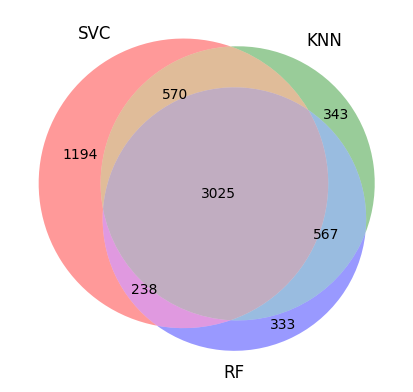

In [115]:
venn3([set(svc_errors), set(knn_errors), set(rf_errors)], ('SVC', 'KNN', 'RF'))

plt.show()

In [116]:
# Overlap of all models
len(
    set.intersection(
        set(svc_errors),
        set(knn_errors),
        set(rf_errors)
    )
) / base_models_df.shape[0]

0.1637436397098625

In [117]:
# Overlap of SVC vs KNN
len(
    set.intersection(
        set(svc_errors),
        set(knn_errors)
    )
) / base_models_df.shape[0]

0.19459781314279528

In [118]:
# Overlap of SVC vs RF
len(
    set.intersection(
        set(svc_errors),
        set(rf_errors)
    )
) / base_models_df.shape[0]

0.17662661037133268

In [119]:
# Overlap of RF vs KNN
len(
    set.intersection(
        set(rf_errors),
        set(knn_errors)
    )
) / base_models_df.shape[0]

0.19443542275630615

## Models Stacking

In [120]:
stacking_model = StackingClassifier(
    estimators=[
        ('svc', svc_best),
        ('knn', knn_best),
        ('rf', rf_best)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

In [121]:
stacking_model.fit(X_train_trans, y_train)
stacking_train_preds = stacking_model.predict(X_train_trans)
stacking_test_preds = stacking_model.predict(X_test_trans)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [122]:
print('Train:')
print(classification_report(y_train, stacking_train_preds), '\n')
print('Test:')
print(classification_report(y_test, stacking_test_preds))

Train:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     25669
           1       0.80      0.79      0.79     29752

    accuracy                           0.78     55421
   macro avg       0.78      0.78      0.78     55421
weighted avg       0.78      0.78      0.78     55421
 

Test:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      8603
           1       0.79      0.78      0.79      9871

    accuracy                           0.77     18474
   macro avg       0.77      0.77      0.77     18474
weighted avg       0.77      0.77      0.77     18474

